In [23]:
from cutList import cutList
from SetConfiguration import SetConfiguration
import ROOT
from ROOT import gROOT,TFile,TH1F,gDirectory,TChain,RDataFrame,SetOwnership
#ROOT.ROOT.EnableImplicitMT()
from copy import deepcopy
import os
import json
import numpy as np
import math
import time
import sys
import logging
import json
#Dask imports
import dask
from dask.distributed import LocalCluster, Client
from dask.distributed.client import _get_global_client
#%matplotlib notebook
from dask_kubernetes.operator import KubeCluster
import glob
import subprocess
import psutil
import matplotlib.pyplot as plt
import asyncio
from dask.distributed import performance_report
from dask.diagnostics import Profiler, ResourceProfiler, CacheProfiler
import yaml

In [24]:
#pip install --upgrade dask==2024.3.1
print(dask.__version__)

2022.11.0


In [25]:
#non necessario ai fini di questo codice
import hashlib
import os
username = os.environ['JUPYTERHUB_USER']
hash_object = hashlib.md5(f'{username}'.encode())
password = hash_object.hexdigest()
print(f"Username: {username}\npassword: {password}")
from dask.distributed import Client, fire_and_forget

Username: adonofrio
password: e8633ddb1c845c33b65419c5aaee0103


In [26]:
distributed = True

local_cluster = False

nmaxpartition = 35

#sanity check
if distributed == True and local_cluster == True:
    print('ERROR!!!!')

In [5]:
cluster.close() # Nel caso sia gia' aperto
time.sleep(10)

In [27]:
from dask_kubernetes.operator import KubeCluster

# Leggi il file di configurazione YAML
with open('/home/jovyan/work/pnrr-atlas-analysis/mydask-config.yaml', 'r') as file:
    config = yaml.safe_load(file)

# Estrarre le risorse CPU e altre impostazioni necessarie dal file YAML
cpu_resource = config['distributed']['worker']['resources']['custom_cpu_range']  

client = _get_global_client()

if client is not None:
    client.shutdown()
    client.close()


cluster = KubeCluster(
    name=f'{username}',
    namespace=f'user-{username}',
    image='bspisso/afworker:v2',# nuova immagine di Dino con voms !!!!!
    #image='bspisso/afworker:v1',# nuova immagine !!!!!
    #image='onofrioa/test_dask:v3',# nuova immagine !!!!!
    n_workers=9, 
    worker_command=[
        'dask-worker',
        '--name=$(DASK_WORKER_NAME)',
        '--local-directory=temp_dir', 
        '--nthreads', '8', #8 nuova, 4-5 vecchia
        '--death-timeout', '60',
        '--memory-limit','16Gi' #16 nuova, 5-6 sulla vecchia
    ],
     #port_forward_cluster_ip=True,
    resources={
        "requests": {
            "memory": "16Gi", #16 nuova, 5-6 sulla vecchia
            "cpu": "8" #8 nuova, 4-5 vecchia
        },
        "limits": {
            "memory": "16Gi", #16 nuova, 5-6 sulla vecchia
            "cpu": "8" #8 nuova, 4-5 vecchia
        }
    }
)

print(cluster.dashboard_link)


http://adonofrio-scheduler.user-adonofrio:8787/status


In [28]:
c_distributed = Client(cluster)
time.sleep(10)
c_distributed

<Client: 'tcp://10.42.97.125:8786' processes=9 threads=72, memory=144.00 GiB>

In [8]:
import subprocess

def check_cluster_configuration():
    try:
        command_output = subprocess.check_output(["kubectl", "cluster-info"])
        if b"kubernetes master" in command_output.lower():
            # Lo stato del cluster è corretto
            return True
        else:
            # Lo stato del cluster non è corretto
            return False
    except subprocess.CalledProcessError as e:
        print("Errore durante il controllo dello stato del cluster:", e)
        return False

In [9]:
n_workers=len(c_distributed.scheduler_info()['workers'])
inputpath = "/home/jovyan/temp_dir/dask-worker-space/"
#inputpath = "/home/jovyan/temp_dir/dask-scratch-space/"

def mv_file(file):
    path = glob.glob(inputpath + "worker-*/")[0]
    subprocess.run(['mv', path + file, inputpath])
    
    
'''
# Funzione per distribuire e spostare i file
def distribute_and_move_files(file,c_distributed,inputpath):
    # Trova l'indice della sottostringa "mc16"
    print("funziona 0.2", inputpath)
    index = file.find("mc16")   
    print("funziona 0.3", index)
    # Estrai la parte della stringa a partire dall'indice trovato
    rootfile = file[index:] 
    print("funziona 0.4", rootfile)
    c_distributed.upload_file(inputpath+rootfile)
    print("funziona 0.5")
    # Attendi che tutti i worker siano pronti
    c_distributed.wait_for_workers(len(c_distributed.scheduler_info()['workers']))
    print("funziona 0.6")
    # Esegui la funzione mv_file su tutti i worker
    c_distributed.run(mv_file, rootfile)
    print("funziona 0.7")
    # Attendi che tutti i worker abbiano completato l'operazione di spostamento
    c_distributed.wait_for_workers(len(c_distributed.scheduler_info()['workers']))
    print("funziona 0.8")
    # Restituisci la lista dei file spostati
    moved_files = [inputpath + rootfile]
    print("funziona 0.9")
    return moved_files
'''
import logging

# Imposta il livello di logging
#logging.basicConfig(level=logging.DEBUG)

# Funzione per distribuire e spostare i file
def distribute_and_move_files(file, c_distributed, inputpath):
    logging.debug("Funzione distribute_and_move_files avviata.")
    index = file.find("mc16")   
    logging.debug("Indice trovato: %d", index)
    rootfile = file[index:] 
    logging.debug("Root file: %s", rootfile)
    print("ciao")
    c_distributed.wait_for_workers(len(c_distributed.scheduler_info()['workers']))
    check_cluster_configuration()
    c_distributed.upload_file(inputpath + rootfile)
    logging.debug("File %s caricato.", rootfile)
    
    # Attesa per assicurarsi che l'upload del file sia completato
    while not file_is_uploaded(c_distributed, rootfile):
        time.sleep(1)
    
    c_distributed.wait_for_workers(len(c_distributed.scheduler_info()['workers']))
    c_distributed.run(mv_file, rootfile)
    logging.debug("Funzione mv_file eseguita su tutti i worker.")
    c_distributed.wait_for_workers(len(c_distributed.scheduler_info()['workers']))
    moved_files = [inputpath + rootfile]
    logging.debug("Lista dei file spostati: %s", moved_files)
    return moved_files

def file_is_uploaded(c_distributed, filename):
    return os.path.exists(filename)

In [10]:
# Funzione per ottenere l'utilizzo della CPU di ogni worker
def get_worker_cpu_usage(client):
    workers = list(client.scheduler_info()["workers"].keys())
    cpu_usage = {}

    for worker in workers:
        # Ottieni l'utilizzo della CPU per ogni worker
        cpu_percent = client.run(psutil.cpu_percent)

        # Calcola la media dell'utilizzo della CPU per ogni worker
        avg_cpu_percent = sum(cpu_percent.values()) / len(cpu_percent)
        
        # Memorizza i risultati nell'oggetto cpu_usage
        cpu_usage[worker] = avg_cpu_percent

    return cpu_usage


In [11]:
def create_connection():
    """
    Setup connection to a Dask cluster. Two ingredients are needed:
    1. Creating a cluster object that represents computing resources. This can be
       done in various ways depending on the type of resources at disposal. To use
       only the local machine (e.g. your laptop), a `LocalCluster` object can be
       used. This step can be skipped if you have access to an existing Dask
       cluster; in that case, the cluster administrator should provide you with a
       URL to connect to the cluster in step 2. More options for cluster creation
       can be found in the Dask docs at
       http://distributed.dask.org/en/stable/api.html#cluster .
    2. Creating a Dask client object that connects to the cluster. This accepts
       directly the object previously created. In case the cluster was setup
       externally, you need to provide an endpoint URL to the client, e.g.
       'https://myscheduler.domain:8786'.
 
    Through Dask, you can connect to various types of cluster resources. For
    example, you can connect together a set of machines through SSH and use them
    to run your computations. This is done through the `SSHCluster` class. For
    example:
 
    ```python
    from dask.distributed import SSHCluster
    cluster = SSHCluster(
        # A list with machine host names, the first name will be used as
        # scheduler, following names will become workers.
        hosts=["machine1","machine2","machine3"],
        # A dictionary of options for each worker node, here we set the number
        # of cores to be used on each node.
        worker_options={"nprocs":4,},
    )
    ```
 
    Another common usecase is interfacing Dask to a batch system like HTCondor or
    Slurm. A separate package called dask-jobqueue (https://jobqueue.dask.org)
    extends the available Dask cluster classes to enable running Dask computations
    as batch jobs. In this case, the cluster object usually receives the parameters
    that would be written in the job description file. For example:
 
    ```python
    from dask_jobqueue import HTCondorCluster
    cluster = HTCondorCluster(
        cores=1,
        memory='2000MB',
        disk='1000MB',
    )
    # Use the scale method to send as many jobs as needed
    cluster.scale(4)
    ```
 
    In this tutorial, a cluster object is created for the local machine, using
    multiprocessing (processes=True) on 4 workers (n_workers=4) each using only
    1 core (threads_per_worker=1).
    """
    #Client locale   
    #cluster = LocalCluster(n_workers=2, threads_per_worker=1, processes=True,dashboard_address=':8786')
    cluster = LocalCluster(n_workers=2, threads_per_worker=1, processes=True, dashboard_address=':8786')
    client = Client(cluster)
    client
    #cluster.close()
    return client

connection = create_connection()

2024-07-30 14:45:26,814 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-94qjwlv8', purging
2024-07-30 14:45:26,814 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-d__luufy', purging


In [12]:
## Auxiliary function to count time
def timeStr(seconds):
    hours=seconds//3600
    seconds=seconds-hours*3600
    minutes=seconds//60
    seconds=seconds-minutes*60
    return f"{hours}h:{minutes}m:{int(seconds*10+0.5)/10.}s"

In [13]:
## Auxiliary function to define samples to be processed
def pathResolver(sampleName, mc):
    listFiles = []
    campaigns = ["mc16a", "mc16d", "mc16e"]
    #campaigns = ["mc16a"]
    currentDir="/home/jovyan/work/inputs-pnrr-atlas-analysis"
    if sampleName == "Data":
        currentDir+="/data"
        if mc == "mc16a":
            listFiles.append(currentDir+"/data15.root")
            listFiles.append(currentDir+"/data16.root")
        elif mc == "mc16d":
            listFiles.append(currentDir+"/data17.root")
        elif mc == "mc16e":
            listFiles.append(currentDir+"/data18.root")
        else:
            listFiles.append(currentDir+"/data15.root")
            listFiles.append(currentDir+"/data16.root")
            listFiles.append(currentDir+"/data17.root")
            listFiles.append(currentDir+"/data18.root")

    elif sampleName == "Fakes":
        if mc == "mc16a" or mc == "mc16d" or mc == "mc16e":
            listFiles.append(currentDir+"/"+mc+"/Fake_Others.root")
            listFiles.append(currentDir+"/"+mc+"/Fake_ttHnoDilep.root")
            listFiles.append(currentDir+"/"+mc+"/Fake_Others_twZ_Znunu.root")
            listFiles.append(currentDir+"/"+mc+"/Fake_VV.root")
            listFiles.append(currentDir+"/"+mc+"/Fake_Wt.root")
            listFiles.append(currentDir+"/"+mc+"/Fake_Zjets.root")
            listFiles.append(currentDir+"/"+mc+"/Fake_ttZ.root")
            listFiles.append(currentDir+"/"+mc+"/Fake_ttbar.root")
        else:
            for mc in campaigns:
                listFiles.append(currentDir+"/"+mcc+"/Fake_Others.root")
                listFiles.append(currentDir+"/"+mcc+"/Fake_ttHnoDilep.root")
                listFiles.append(currentDir+"/"+mcc+"/Fake_Others_twZ_Znunu.root")
                listFiles.append(currentDir+"/"+mcc+"/Fake_VV.root")
                listFiles.append(currentDir+"/"+mcc+"/Fake_Wt.root")
                listFiles.append(currentDir+"/"+mcc+"/Fake_Zjets.root")
                listFiles.append(currentDir+"/"+mcc+"/Fake_ttZ.root")
                listFiles.append(currentDir+"/"+mcc+"/Fake_ttbar.root")

        if mc == "mc16a":
            listFiles.append(currentDir+"/"+mc+"/Fake_data15.root")
            listFiles.append(currentDir+"/"+mc+"/Fake_data16.root")
        elif mc == "mc16d":
            listFiles.append(currentDir+"/"+mc+"/Fake_data17.root")
        elif mc == "mc16e":
            listFiles.append(currentDir+"/"+mc+"/Fake_data18.root")
        else:
            listFiles.append(currentDir+"/mc16a/Fake_data15.root")
            listFiles.append(currentDir+"/mc16a/Fake_data16.root")
            listFiles.append(currentDir+"/mc16d/Fake_data17.root")
            listFiles.append(currentDir+"/mc16e/Fake_data18.root")

    else:
        if sampleName=="Others":
            if mc == "mc16a" or mc == "mc16d" or mc == "mc16e":
                listFiles.append(currentDir+"/"+mc+"/Others_nottHnoDilep.root")
                listFiles.append(currentDir+"/"+mc+"/ttHnoDilep.root")
                listFiles.append(currentDir+"/"+mc+"/Others_twZ_Znunu.root")
            else:
                for mc in campaigns:
                    listFiles.append(currentDir+"/"+mcc+"/Others_nottHnoDilep.root")
                    listFiles.append(currentDir+"/"+mcc+"/ttHnoDilep.root")
                    listFiles.append(currentDir+"/"+mcc+"/Others_twZ_Znunu.root")
        else:
            if mc == "mc16a" or mc == "mc16d" or mc == "mc16e":
                listFiles.append(currentDir+"/"+mc+"/"+sampleName+".root")
            else:
                for mcc in campaigns:
                    listFiles.append(currentDir+"/"+mcc+"/"+sampleName+".root")
    print("listFiles: ", listFiles)
    return listFiles

In [14]:
## Auxiliary function to define luminosity
def GetLumi(mc):
    lumi = 1
    if mc=="mc16a": lumi=32.9881+3.21956
    elif mc=="mc16d": lumi=44.3074
    elif mc=="mc16e": lumi=58.4501
    elif mc=="Run2": lumi=58.4501+44.3074+32.9881+3.21956
    else: lumi=-1
    return lumi

print(GetLumi("Run2"))

138.96516


In [15]:
## Auxiliary function to check if TFile(s) and TTree(s) exist
def checkTree(treeName,fileName):
    hereTree=False
    logging.getLogger('HistogramExtractor').debug("Openening filename: %s", fileName)
    f=TFile(fileName)
    if f.Get(treeName): hereTree=True
    else: logging.getLogger('HistogramExtractor').error("Unable to find treename: %s", treeName)
    f.Close()
    del f
    return hereTree

In [16]:
## Auxiliary function to append extra weights
def addWeight(oldList,newWeight):
    newList = deepcopy(oldList)
    newList.extend(newWeight)
    return newList


In [17]:
## Auxiliary function to replace a weight
def replaceWeight(oldList,oldWeight,newWeight):
    newList = deepcopy(oldList)
    newList[oldList.index(oldWeight)] = newWeight
    return newList

In [18]:
if distributed == True or local_cluster == True:
    RDF = ROOT.RDF.Experimental.Distributed.Dask.RDataFrame
else:
    RDF = ROOT.RDataFrame   

## Auxiliary function to create a RDataFrame
def getRDF(nmaxpartition, sample,c_distributed,connection,distributed,input_files,suffix=""):    

    rdSample = None  # Inizializzazione di rdSample
   
    tc = TChain(sample + suffix)
    
    for el in input_files:
        logging.getLogger('HistogramExtractor').info("Picking up " + sample + suffix + " TTree from ")
        if checkTree(sample+suffix, el): tc.Add(el)
        if len(tc.GetListOfFiles())==0:
            logging.getLogger('HistogramExtractor').error(f"{tc.GetName()} has no root files associated")
            sys.exit(-1)
        SetOwnership(tc, False)
        
    if distributed == True:
        print("sono in distributed")
        m_client = c_distributed
        output_file = "combined.root"
        output = ROOT.TFile(output_file, "RECREATE")
        # Clona la catena nel nuovo file di output
        combined_tree = tc.CloneTree(-1, "fast")
        # Scrivi il TTree combinato nel file di output
        output.cd()
        combined_tree.Write(sample + suffix)                         
        rdSample = RDF(sample + suffix, output, npartitions=nmaxpartition,daskclient=m_client)  
        print("Numero di eventi nel DataFrame rdSample:", rdSample.Count().GetValue())
        output.Close()
             
    # Create an RDataFrame that will use Dask as a backend for computations
    elif local_cluster ==True:
        m_client = connection
        rdSample = RDF(tc,npartitions=nmaxpartition,daskclient=m_client)                    
    else:
        rdSample = RDF(tc)
        SetOwnership(rdSample,False)
    
    if "Preselection" in cfg.cutsDict.keys():
        logging.getLogger('HistogramExtractor').debug(f"Detected key Preselection in cutsDic ->  applying preselection filter (be sure your preselection is loose enough wrt SR selection)")
        rdSample = rdSample.Filter(cfg.cutsDict["Preselection"],"Preselection")

    return rdSample


In [19]:
## Auxiliary function to extract histogram from the given RDF, sample, regions, systematic
def getHistos(Type,rdSample,sample,channels,cfg,systWeight="1"):
    if sample == "Data": Type = "_NONE"
    listHisto = {}
    nBins = 1
    print("Type: ",Type)
    print("rdSample: ",rdSample)
    print("sample: ", sample)
    print("channels: ", channels)
    print("cfg: ", cfg)
    
    for ch in channels:
        addCuts = []
        if sample != "Fakes" and sample != "Data": addCuts.append(cfg.PromptLep)
        if not sample == "Fakes": addCuts.append(cfg.IsoSig)
        if not sample == "Data": addCuts.append(cfg.BadEvents)
        additionalCuts="( "+" && ".join(addCuts)+" )"

        cut=cfg.cutsDict[ch]
        cut+=" && ("+additionalCuts+")"
        weights="*".join(addWeight(cfg.weights,["("+systWeight+")"]))
        if sample == "Fakes": 
            weights += "*"+cfg.fakeWeight+"*"+str(cfg.outputLumi)
        elif sample == "Data": 
            logging.getLogger('HistogramExtractor').info("Data, no weights to add")
        else: 
            weights +="*"+str(cfg.outputLumi)

        if sample in cfg.normalizationFactor.keys(): 
            weights +="*"+str(cfg.normalizationFactor[sample][0])
        
        histoName="h"+sample+Type+"_"+ch+"_obs_cuts"
        histo=None
        
        print("Numero di eventi nel DataFrame rdSample:", rdSample.Count().GetValue())
        
        chRDF=rdSample.Filter(cut,ch+" selection").Define("TotWeight","float val="+weights+";return val;").Define("varToPlot","float val=1.; return val;")

        print("chRDF ", chRDF)
        print("histoname ", histoName)
        
        print("Contenuto DataFrame chRDF:")
        print("Numero di eventi nel DataFrame chRDF:", chRDF.Count().GetValue())
        
        histo = chRDF.Histo1D(ROOT.RDF.TH1DModel(histoName,histoName,1,0.5,1.5),"varToPlot","TotWeight").GetValue()
        
        logging.getLogger('HistogramExtractor').debug("Defined histo: " + histoName + " with selection --> " + cut + " and weights --> " + weights)
        histo.SetBit(False)
        if histo.GetBinContent(0)!=0:
            histo.SetBinContent(1,histo.GetBinContent(0.)+histo.GetBinContent(1.))
            histo.SetBinContent(0,0.)
        if histo.GetBinContent(nBins+1)!=0:
            histo.SetBinContent(nBins+1,histo.GetBinContent(nBins)+histo.GetBinContent(nBins+1))
            histo.SetBinContent(nBins+1,0.)
        if histo.Integral()<=0:
            for i in range(1,nBins+1):
                histo.SetBinContent(i,0.0001)
        SetOwnership(histo, False)
        listHisto[ch]=histo
    return listHisto

In [20]:
def applyTheorySyst(sample,ch,systName,upVar,downVar,cfg):
    hNomName="h"+sample+"Nom_"+ch+"_obs_cuts"
    hUpName = "h"+sample+systName+"High_"+ch+"_obs_cuts"
    hSystUp = cfg.hists[hNomName].Clone(hUpName)
    hSystUp.SetBinContent(1, upVar*cfg.hists[hNomName].GetBinContent(1))
    hSystUp.SetBinError(1, 0.)
    hDownName = "h"+sample+systName+"Low_"+ch+"_obs_cuts"
    hSystDown = cfg.hists[hNomName].Clone(hDownName)
    hSystDown.SetBinContent(1, downVar*cfg.hists[hNomName].GetBinContent(1))
    hSystDown.SetBinError(1, 0.)
    return [hSystUp,hSystDown]

In [21]:
# Funzione per monitorare le risorse CPU
def monitor_cpu_usage():
    worker = get_worker()
    worker_id = worker.address
    cpu_usage = psutil.cpu_percent(interval=1)
    return worker_id, cpu_usage

# Funzione per raccogliere i dati dai worker nodes
def collect_cpu_usage(client, func, *args):
    futures = client.run(func, *args)
    results = client.gather(futures)
    return results

# Funzione per creare un grafico
def plot_cpu_usage(cpu_usages):
    worker_ids = list(cpu_usages.keys())
    usages = list(cpu_usages.values())
    
    plt.figure(figsize=(10, 6))
    plt.bar(worker_ids, usages, color='blue')
    plt.xlabel('Worker Nodes')
    plt.ylabel('CPU Usage (%)')
    plt.title('CPU Usage per Worker Node')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


listFiles:  ['/home/jovyan/work/inputs-pnrr-atlas-analysis/mc16a/Wt.root', '/home/jovyan/work/inputs-pnrr-atlas-analysis/mc16d/Wt.root', '/home/jovyan/work/inputs-pnrr-atlas-analysis/mc16e/Wt.root']
3
distribuito?  True
Indice trovato: %d 45
Root file: %s mc16a/Wt.root
n_workers: %d 9
input file: %s /home/jovyan/temp_dir/dask-worker-space/mc16a/Wt.root
suffix =  _WEIGHTS
entries in input file:  48531
False
True
eseguito upload
Indice trovato: %d 45
Root file: %s mc16d/Wt.root
n_workers: %d 9
input file: %s /home/jovyan/temp_dir/dask-worker-space/mc16d/Wt.root
suffix =  _WEIGHTS
entries in input file:  62586
False
True
eseguito upload
Indice trovato: %d 45
Root file: %s mc16e/Wt.root
n_workers: %d 9
input file: %s /home/jovyan/temp_dir/dask-worker-space/mc16e/Wt.root
suffix =  _WEIGHTS
entries in input file:  53071
False
True
eseguito upload
input_files:  ['/home/jovyan/temp_dir/dask-worker-space/mc16a/Wt.root', '/home/jovyan/temp_dir/dask-worker-space/mc16d/Wt.root', '/home/jovyan/temp

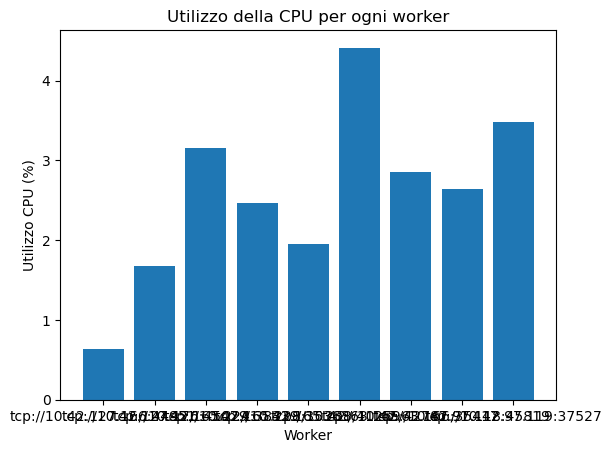

Storing histograms in file: histos.root


2024-07-30 15:07:03,697 - distributed.nanny - WARNING - Restarting worker


Done building file with histograms
Tempo impiegato in secondi:  1295.3747198581696


In [22]:

############################################################### MAIN ##### HERE EVERYTHING STARTS: LET'S DO IT!
logging.basicConfig(level=logging.INFO, stream=sys.stdout)

## Please, read the following comments: it is a trade-off as the code is being developed. It will be removed once the final implementation will be ready!
## If "Run2" is given to the campaign string, the below configuration will run for 1 sample only, i.e. Wt, for all mc campaigns.
## Otherwise, if "mc16X", X=a||d||e, a single mc campaign will be used for all samples.
campaign = "Run2"
cfg = SetConfiguration()
cfg.outputLumi = GetLumi(campaign)
cfg.outHistoFile = "histos.root"
cfg.nomName = "_WEIGHTS"

## Monte-Carlo weights
cfg.weights = ["weight","WeightEventsbTag","WeightEventsPU"]
cfg.fakeWeight = "fakeWeight"

## Load region map with associated cuts
cList = cutList(Selection="Stop4b")
cfg.cutsDict = cList.cutsDict
cfg.IsoSig = cList.IsoSigWeight
cfg.PromptLep = cList.PromptOriginWeight
cfg.FakeLep = cList.FakeOriginWeight
cfg.BadEvents = cList.BadEvents

Channels=["Stop4b_SRA", "Stop4b_SRB"]

## SYSTEMATICS: 1-side + 2-side
listEGSymSyst = ["EG_RESOLUTION_ALL","EG_SCALE_ALL"]
listJESSymSyst = ["JET_EtaIntercalibration_NonClosure_highE","JET_EtaIntercalibration_NonClosure_negEta","JET_EtaIntercalibration_NonClosure_posEta","JET_Flavor_Response","JET_GroupedNP_1","JET_GroupedNP_2","JET_GroupedNP_3"]
listJERSymSyst = ["JET_JER_DataVsMC_MC16","JET_JER_EffectiveNP_1","JET_JER_EffectiveNP_2","JET_JER_EffectiveNP_3","JET_JER_EffectiveNP_4","JET_JER_EffectiveNP_5","JET_JER_EffectiveNP_6","JET_JER_EffectiveNP_7restTerm"]
listMUONSymSyst = ["MUON_ID","MUON_MS","MUON_SAGITTA_RESBIAS","MUON_SAGITTA_RHO","MUON_SCALE"]
listMETAsymSyst = ["MET_SoftTrk_ResoPara","MET_SoftTrk_ResoPerp"]
listMETSymSyst = ["MET_SoftTrk_Scale"]
treeSystTwoSide = listEGSymSyst + listJESSymSyst + listMUONSymSyst + listMETSymSyst
treeSystOneSide = listMETAsymSyst + listJERSymSyst

## SYSTEMATICS: WEIGHT SYSTS
listWeight_EL_EFF = ["WeightEventselSF_EL_EFF_ChargeIDSel_TOTAL_1NPCOR_PLUS_UNCOR","WeightEventselSF_EL_EFF_ID_TOTAL_1NPCOR_PLUS_UNCOR","WeightEventselSF_EL_EFF_Iso_TOTAL_1NPCOR_PLUS_UNCOR","WeightEventselSF_EL_EFF_Reco_TOTAL_1NPCOR_PLUS_UNCOR"]
listWeight_MUON_EFF = ["WeightEventsmuSF_MUON_EFF_BADMUON_STAT","WeightEventsmuSF_MUON_EFF_BADMUON_SYS","WeightEventsmuSF_MUON_EFF_ISO_STAT","WeightEventsmuSF_MUON_EFF_ISO_SYS","WeightEventsmuSF_MUON_EFF_RECO_STAT","WeightEventsmuSF_MUON_EFF_RECO_STAT_LOWPT","WeightEventsmuSF_MUON_EFF_RECO_SYS","WeightEventsmuSF_MUON_EFF_RECO_SYS_LOWPT","WeightEventsmuSF_MUON_EFF_TTVA_STAT","WeightEventsmuSF_MUON_EFF_TTVA_SYS"]
listWeight_bTag = ["WeightEventsbTag_FT_EFF_B_systematics","WeightEventsbTag_FT_EFF_C_systematics","WeightEventsbTag_FT_EFF_Light_systematics","WeightEventsbTag_FT_EFF_extrapolation","WeightEventsbTag_FT_EFF_extrapolation_from_charm"]
listWeight_JVT = ["WeightEventsJVT_JET_JvtEfficiency"]
listWeight_PU = ["WeightEventsPU_PRW_DATASF"]
weightSyst = listWeight_EL_EFF + listWeight_MUON_EFF + listWeight_bTag + listWeight_JVT + listWeight_PU

## List of samples: the following if-clause is a hack to quickly test changes on a single sample. See comment above, at the beginning of the workflow
bkgSampleList=["Wt"]
if campaign == "mc16a" or campaign == "mc16d" or campaign == "mc16e":
    bkgSampleList.append("ttbar")
    bkgSampleList.append("Zjets")
    bkgSampleList.append("VV")
    bkgSampleList.append("ttZ")
    bkgSampleList.append("Others")
leftSampleList=["Fakes","Data"]
cfg.normalizationFactor = {"VV":[1.00,0.25],"ttbar":[0.90,0.12]}


# Inizia a misurare il tempo
start_time = time.time()

        
#with Profiler() as prof, ResourceProfiler(dt=0.25) as rprof, CacheProfiler() as cprof:   
with performance_report(filename="dask-report.html"):
    ## Loop to extract nominal yields
    for sample in bkgSampleList:
        StartTotTime=time.time()
        StarTime = time.time()

        input_files = pathResolver(sample,campaign)
        print(len(input_files))
    
        start_time_copy = time.time()
    
        if distributed == True:
            print("distribuito? ", distributed)
            copied_input_files = []
            for file in input_files:
                c_distributed.wait_for_workers(n_workers)
                index = file.find("mc16")   
                print("Indice trovato: %d", index)
                rootfile = file[index:] 
                print("Root file: %s", rootfile)
                print("n_workers: %d", n_workers)
                print("input file: %s", inputpath+rootfile)
                file = ROOT.TFile.Open(inputpath + rootfile)
                m_suffix = cfg.nomName
                print("suffix = ", m_suffix)
                print("entries in input file: ", file.Get(sample+m_suffix).GetEntries())
                print(check_cluster_configuration())
                print(file_is_uploaded(c_distributed,inputpath+rootfile))
                c_distributed.upload_file(inputpath+rootfile)
                print("eseguito upload")
                c_distributed.wait_for_workers(n_workers)
                c_distributed.run(mv_file,rootfile) 
                c_distributed.wait_for_workers(n_workers)
                input_file=inputpath+rootfile
                copied_input_files.append(input_file)
            input_files = copied_input_files
            print("input_files: ", input_files)
            '''    
                print("filename: ", file)
                input_file = distribute_and_move_files(file,c_distributed,inputpath)
                copied_input_files.append(input_file)
            input_files = copied_input_files        
            '''
        else:
            c_distributed = None
            input_files = pathResolver(sample,campaign)
    
    
        # Termina la misurazione del tempo
        end_time_copy = time.time()

        # Calcola il tempo trascorso
        elapsed_time_copy = end_time_copy - start_time_copy

        # Stampa il risultato
        print("Tempo impiegato per copiare i files in secondi: ", elapsed_time_copy)   

        
        nomRDF = getRDF(nmaxpartition,sample,c_distributed,connection,distributed,input_files,cfg.nomName) 
    
        nominalHisto = getHistos("Nom",nomRDF,sample,Channels,cfg)
    
        for hist in nominalHisto.keys(): cfg.hists[nominalHisto[hist].GetName()]=nominalHisto[hist]
        print("funziona 4 ", nominalHisto[hist].GetName())
        print("funziona 5 ", nominalHisto[hist].GetEntries())
        logging.getLogger('HistogramExtractor').info('Sample: ' + sample + ' -> Produced nominal histos in ' + timeStr(time.time()-StarTime))
    
        '''
        if distributed or local_cluster:
            # Verifica che il client sia un client Dask distribuito
            if isinstance(c_distributed, Client):
                worker_cpu_usage = get_worker_cpu_usage(c_distributed)
                print("Utilizzo della CPU di ogni worker:", worker_cpu_usage)

                # Visualizza i risultati in un grafico
                workers = list(worker_cpu_usage.keys())
                cpu_percentages = list(worker_cpu_usage.values())

                plt.bar(workers, cpu_percentages)
                plt.xlabel('Worker')
                plt.ylabel('Utilizzo CPU (%)')
                plt.title('Utilizzo della CPU per ogni worker')
                plt.show()

            else:
                print("Il client Dask non è configurato correttamente.")
        '''
    
        
        ## Loop to extract 1-side systematics
        for syst in treeSystOneSide:
            StarTime = time.time()
            nameSystUp = "_"+syst+"__1up" if not syst=="MET_SoftTrk_ResoPara" and not syst=="MET_SoftTrk_ResoPerp" else "_"+syst
            systUpRDF=getRDF(nmaxpartition,sample,c_distributed,connection,distributed,input_files,nameSystUp)
            systUpHisto=getHistos(syst+"High",systUpRDF,sample,Channels,cfg)
            for uphist in systUpHisto.keys(): cfg.hists[systUpHisto[uphist].GetName()]=systUpHisto[uphist]
            for ch in Channels:
                ## Symmetrize systematic in each channel and introduce down variation
                logging.getLogger('HistogramExtractor').info("Channel: " + ch + " --- Symmetrize 1-side SYST: " + syst)
                hNomName="h"+sample+"Nom_"+ch+"_obs_cuts"
                hUpName="h"+sample+syst+"High_"+ch+"_obs_cuts"
                hDownName="h"+sample+syst+"Low_"+ch+"_obs_cuts"
                hDown = cfg.hists[hNomName].Clone(hDownName)
                hDown.Scale(2.0)
                hDown.Add(cfg.hists[hUpName], -1.0)
            for iBin in range(1, hDown.GetNbinsX()+1):
                binVal = hDown.GetBinContent(iBin)
                if binVal < 0.: hDown.SetBinContent(iBin, 0.)
            SetOwnership(hDown, False)
            cfg.hists[hDown.GetName()]=hDown
        logging.getLogger('HistogramExtractor').info("- Produced variation: "+syst+" in "+timeStr(time.time()-StarTime))

        
        ## Loop to extract 2-side systematics
        for syst in treeSystTwoSide:
            StarTime = time.time()
            nameSystUp = "_"+syst+"__1up" if not syst=="MET_SoftTrk_Scale" else "_"+syst+"Up"
            nameSystDown = "_"+syst+"__1down" if not syst=="MET_SoftTrk_Scale" else "_"+syst+"Down"
            systUpRDF  =getRDF(nmaxpartition,sample,c_distributed,connection,distributed,input_files,nameSystUp)
            systUpHisto=getHistos(syst+"High",systUpRDF,sample,Channels,cfg)
            systDownRDF=getRDF(nmaxpartition,sample,c_distributed,connection,distributed,input_files,nameSystDown)
            systDownHisto=getHistos(syst+"Low",systDownRDF,sample,Channels,cfg)
            for uphist in systUpHisto.keys(): cfg.hists[systUpHisto[uphist].GetName()]=systUpHisto[uphist]
            for downhist in systDownHisto.keys(): cfg.hists[systDownHisto[downhist].GetName()]=systDownHisto[downhist]
            logging.getLogger('HistogramExtractor').info("- Produced variation: "+syst+" in "+timeStr(time.time()-StarTime))
        '''
        ## Loop to extract weight systematics
        for syst in weightSyst:
            StarTime = time.time()
            systUpHisto=None
            systDownHisto=None
            if not syst=="WeightEventsPU_PRW_DATASF":
                nomRDF = getRDF(nmaxpartition, sample, c_distributed, connection, distributed, input_files, cfg.nomName)
                systUpHisto=getHistos(syst+"High",nomRDF,sample,Channels,cfg,systWeight=syst+"__1up/"+syst.split("_")[0])
                systDownHisto=getHistos(syst+"Low",nomRDF,sample,Channels,cfg,systWeight=syst+"__1down/"+syst.split("_")[0])
            else:
                weightPUNom=deepcopy(cfg.weights)
                weightPUUp=replaceWeight(weightPUNom,"WeightEventsPU",syst+"__1up")
                weightPUDown=replaceWeight(weightPUNom,"WeightEventsPU",syst+"__1down")
                cfg.weights=weightPUUp
                systUpHisto=getHistos(syst+"High",nomRDF,sample,Channels,cfg)
                cfg.weights=weightPUDown
                systDownHisto=getHistos(syst+"Low",nomRDF,sample,Channels,cfg)
                cfg.weights=weightPUNom
            for uphist in systUpHisto.keys(): cfg.hists[systUpHisto[uphist].GetName()]=systUpHisto[uphist]
            for downhist in systDownHisto.keys(): cfg.hists[systDownHisto[downhist].GetName()]=systDownHisto[downhist]
            logging.getLogger('HistogramExtractor').info("- Produced variation: "+syst+" in "+timeStr(time.time()-StarTime))
        '''
        
        ## Theory systematics
        filename = "originalConfig/InputHF/"+sample+"ThSyst.json"
        thSyst = {}
        if sample == "Wt":
            with open(filename) as json_file: thSyst = json.load(json_file)
            StarTime = time.time()
            systName = "DRvsDS"
            for ch in Channels:
                syst = thSyst[ch]
                DSUp = 1+abs(1-syst["DS"])
                DSDown = 1-abs(1-syst["DS"])
                [systUpHisto,systDownHisto] = applyTheorySyst(sample,ch,systName,DSUp,DSDown,cfg)
                cfg.hists[systUpHisto.GetName()]=systUpHisto
                cfg.hists[systDownHisto.GetName()]=systDownHisto
            logging.getLogger('HistogramExtractor').info("- Produced theory variation: "+systName+" ("+sample+") in "+timeStr(time.time()-StarTime))
        elif sample == "ttbar":
            with open(filename) as json_file: thSyst = json.load(json_file)
            StarTime = time.time()
            systName = "HardScattering"
            for ch in Channels:
                syst = thSyst[ch]
                hardUp = 1+abs(1-syst["hardscattematching"])
                hardDown = 1-abs(1-syst["hardscattematching"])
                [systUpHisto,systDownHisto] = applyTheorySyst(sample,ch,systName,hardUp,hardDown,cfg)
                cfg.hists[systUpHisto.GetName()]=systUpHisto
                cfg.hists[systDownHisto.GetName()]=systDownHisto
            logging.getLogger('HistogramExtractor').info("- Produced theory variation: "+systName+" ("+sample+") in "+timeStr(time.time()-StarTime))

            systName = "PartonShower"
            for ch in Channels:
                syst = thSyst[ch]
                fragUp = 1+abs(1-syst["fraghad"])
                fragDown = 1-abs(1-syst["fraghad"])
                [systUpHisto,systDownHisto] = applyTheorySyst(sample,ch,systName,fragUp,fragDown,cfg)
                cfg.hists[systUpHisto.GetName()]=systUpHisto
                cfg.hists[systDownHisto.GetName()]=systDownHisto
            logging.getLogger('HistogramExtractor').info("- Produced theory variation: "+systName+" ("+sample+") in "+timeStr(time.time()-StarTime))

            systName = "FSR"
            for ch in Channels:
                syst = thSyst[ch]
                FSRup = syst["FSRup"]
                FSRdown = syst["FSRdown"]
                if (FSRup>1 and FSRdown<1) or (FSRup<1 and FSRdown>1):
                    [systUpHisto,systDownHisto] = applyTheorySyst(sample,ch,systName,FSRup,FSRdown,cfg)
                    cfg.hists[systUpHisto.GetName()]=systUpHisto
                    cfg.hists[systDownHisto.GetName()]=systDownHisto
                else:
                    errFSR = max(abs(1-FSRup),abs(1-FSRdown))
                    [systUpHisto,systDownHisto] = applyTheorySyst(sample,ch,systName,1+errFSR,1-errFSR,cfg)
                    cfg.hists[systUpHisto.GetName()]=systUpHisto
                    cfg.hists[systDownHisto.GetName()]=systDownHisto
            logging.getLogger('HistogramExtractor').info("- Produced theory variation: "+systName+" ("+sample+") in "+timeStr(time.time()-StarTime))

            systName = "ISR"
            for ch in Channels:
                syst = thSyst[ch]
                ISRup = syst["ISRup"]
                ISRdown = syst["ISRdown"]
                if (ISRup>1 and ISRdown<1) or (ISRup<1 and ISRdown>1):
                    [systUpHisto,systDownHisto] = applyTheorySyst(sample,ch,systName,ISRup,ISRdown,cfg)
                    cfg.hists[systUpHisto.GetName()]=systUpHisto
                    cfg.hists[systDownHisto.GetName()]=systDownHisto
                else:
                    errISR = max(abs(1-ISRup),abs(1-ISRdown))
                    [systUpHisto,systDownHisto] = applyTheorySyst(sample,ch,systName,1+errISR,1-errISR,cfg)
                    cfg.hists[systUpHisto.GetName()]=systUpHisto
                    cfg.hists[systDownHisto.GetName()]=systDownHisto
            logging.getLogger('HistogramExtractor').info("- Produced theory variation: "+systName+" ("+sample+") in "+timeStr(time.time()-StarTime))

        elif sample == "VV":
            with open(filename) as json_file: thSyst = json.load(json_file)
            StarTime = time.time()
            systName = "Scale"
            for ch in Channels:
                syst = thSyst[ch]
                scaleUp = 1+abs(1-syst["Scale"])
                scaleDown = 1-abs(1-syst["Scale"])
                [systUpHisto,scaleDownHisto] = applyTheorySyst(sample,ch,systName,scaleUp,scaleDown,cfg)
                cfg.hists[systUpHisto.GetName()]=systUpHisto
                cfg.hists[systDownHisto.GetName()]=systDownHisto
            logging.getLogger('HistogramExtractor').info("- Produced theory variation: "+systName+" ("+sample+") in "+timeStr(time.time()-StarTime))

            systName = "CKKW"
            for ch in Channels:
                syst = thSyst[ch]
                CKKW15 = syst["CKKW15"]
                CKKW30 = syst["CKKW30"]
                if (CKKW30>1 and CKKW15<1) or (CKKW30<1 and CKKW15>1):
                    [systUpHisto,systDownHisto] = applyTheorySyst(sample,ch,systName,CKKW30,CKKW15,cfg)
                    cfg.hists[systUpHisto.GetName()]=systUpHisto
                    cfg.hists[systDownHisto.GetName()]=systDownHisto
                else:
                    errCKKW = max(abs(1-CKKW15),abs(1-CKKW30))
                    [systUpHisto,systDownHisto] = applyTheorySyst(sample,ch,systName,1+errCKKW,1-errCKKW,cfg)
                    cfg.hists[systUpHisto.GetName()]=systUpHisto
                    cfg.hists[systDownHisto.GetName()]=systDownHisto
            logging.getLogger('HistogramExtractor').info("- Produced theory variation: "+systName+" ("+sample+") in "+timeStr(time.time()-StarTime))

            systName = "QSF"
            for ch in Channels:
                syst = thSyst[ch]
                QSF025 = syst["QSF025"]
                QSF4 = syst["QSF4"]
                if (QSF4>1 and QSF025<1) or (QSF4<1 and QSF025>1):
                    [QSFUpHisto,QSFDownHisto] = applyTheorySyst(sample,ch,systName,QSF4,QSF025,cfg)
                    cfg.hists[systUpHisto.GetName()]=systUpHisto
                    cfg.hists[systDownHisto.GetName()]=systDownHisto
                else:
                    errQSF = max(abs(1-QSF025),abs(1-QSF4))
                    [systUpHisto,systDownHisto] = applyTheorySyst(sample,ch,systName,1+errQSF,1-errQSF,cfg)
                    cfg.hists[systUpHisto.GetName()]=systUpHisto
                    cfg.hists[systDownHisto.GetName()]=systDownHisto
            logging.getLogger('HistogramExtractor').info("- Produced theory variation: "+systName+" ("+sample+") in "+timeStr(time.time()-StarTime))

        elif sample == "ttZ" or sample == "Others":
            with open(filename) as json_file: thSyst = json.load(json_file)
            StarTime = time.time()
            systName = "xsec"
            for ch in Channels:
                syst = thSyst[ch]
                xsecUp=syst["xsecUp"]
                xsecDown=syst["xsecDown"]
                [systUpHisto,systDownHisto] = applyTheorySyst(sample,ch,systName,xsecUp,xsecDown,cfg)
                cfg.hists[systUpHisto.GetName()]=systUpHisto
                cfg.hists[systDownHisto.GetName()]=systDownHisto
            logging.getLogger('HistogramExtractor').info("- Produced theory variation: "+systName+" ("+sample+") in "+timeStr(time.time()-StarTime))
        
        
        # Fake systematics
        elif sample == "Fakes":
            StarTime = time.time()
            systName = "mcStatFakeErr"
            cfg.fakeWeight="fakeWeight_statUp"
            mcSystUpHisto=getHistos(systName+"High",nomRDF,sample,[Channels[1]],cfg)
            for uphist in mcSystUpHisto.keys(): cfg.hists[mcSystUpHisto[uphist].GetName()]=mcSystUpHisto[uphist]
            cfg.fakeWeight="fakeWeight_statDown"
            mcSystDownHisto=getHistos(systName+"Low",nomRDF,sample,[Channels[1]],cfg)
            for downhist in mcSystDownHisto.keys(): cfg.hists[mcSystDownHisto[downhist].GetName()]=mcSystDownHisto[downhist]
            logging.getLogger('HistogramExtractor').info("- Produced theory variation: "+systName+" ("+sample+") in "+timeStr(time.time()-StarTime))

            systName = "compSystFakeErr"
            cfg.fakeWeight="fakeWeight_compSyst_SRAUp"
            compSystUpHisto=getHistos(systName+"High",nomRDF,sample,[Channels[0]],cfg)
            for uphist in compSystUpHisto.keys(): cfg.hists[compSystUpHisto[uphist].GetName()]=compSystUpHisto[uphist]
            cfg.fakeWeight="fakeWeight_compSyst_SRBUp"
            compSystUpHisto=getHistos(systName+"High",nomRDF,sample,[Channels[1]],cfg)
            for uphist in compSystUpHisto.keys(): cfg.hists[compSystUpHisto[uphist].GetName()]=compSystUpHisto[uphist]
            cfg.fakeWeight="fakeWeight_compSyst_SRADown"
            compSystDownHisto=getHistos(systName+"Low",nomRDF,sample,[Channels[0]],cfg)
            for downhist in compSystDownHisto.keys(): cfg.hists[compSystDownHisto[downhist].GetName()]=compSystDownHisto[downhist]
            cfg.fakeWeight="fakeWeight_compSyst_SRBDown"
            compSystDownHisto=getHistos(systName+"Low",nomRDF,sample,[Channels[1]],cfg)
            for downhist in compSystDownHisto.keys(): cfg.hists[compSystDownHisto[downhist].GetName()]=compSystDownHisto[downhist]
            logging.getLogger('HistogramExtractor').info("- Produced theory variation: "+systName+" ("+sample+") in "+timeStr(time.time()-StarTime))

            systName = "ErrSSFakeSRA"
            specialFNPRegionError = (pow(10,0.5)/10.)
            [systUpHisto,systDownHisto] = applyTheorySyst(sample,Channels[0],systName,1+specialFNPRegionError,1-specialFNPRegionError,cfg)
            cfg.hists[systUpHisto.GetName()]=systUpHisto
            cfg.hists[systDownHisto.GetName()]=systDownHisto
            logging.getLogger('HistogramExtractor').info("- Produced theory variation: "+systName+" ("+sample+") in "+timeStr(time.time()-StarTime))

            systName = "ClosureFakeErr"
            thSyst = {}
            with open("originalConfig/InputHF/FNPClosureError.json") as json_file: thSyst = json.load(json_file)
            closeUp = 1+thSyst[Channels[1]]
            closeDown = 1-thSyst[Channels[1]]
            [systUpHisto,systDownHisto] = applyTheorySyst(sample,Channels[1],systName,closeUp,closeDown,cfg)
            cfg.hists[systUpHisto.GetName()]=systUpHisto
            cfg.hists[systDownHisto.GetName()]=systDownHisto
            logging.getLogger('HistogramExtractor').info("- Produced theory variation: "+systName+" ("+sample+") in "+timeStr(time.time()-StarTime))

        else: logging.getLogger('HistogramExtractor').warning("Unable to find theory systematics for sample" + sample)
        
    
    
## Finally, extract fake and data nominal yields
#for sample in leftSampleList:
#    StarTime = time.time()
#    input_files = pathResolver(sample,campaign)
#    systNONE = "_NONE" if sample == "Data" else cfg.nomName
#    nomRDF = getRDF(sample,input_files,systNONE)
#    nominalHisto = getHistos("Nom",nomRDF,sample,Channels,cfg)
#    for hist in nominalHisto.keys(): cfg.hists[nominalHisto[hist].GetName()]=nominalHisto[hist]
#    logging.getLogger('HistogramExtractor').info("Sample: " + sample + " -> Produced nominal histos in " + timeStr(time.time()-StarTime))

#from dask.diagnostics import visualize
#visualize([prof, rprof, cprof])
'''
if cluster is not None:
    cluster.close()
'''   

if distributed or local_cluster:
    # Verifica che il client sia un client Dask distribuito
    if isinstance(c_distributed, Client):
        worker_cpu_usage = get_worker_cpu_usage(c_distributed)
        print("Utilizzo della CPU di ogni worker:", worker_cpu_usage)
        # Visualizza i risultati in un grafico
        workers = list(worker_cpu_usage.keys())
        cpu_percentages = list(worker_cpu_usage.values())

        plt.bar(workers, cpu_percentages)
        plt.xlabel('Worker')
        plt.ylabel('Utilizzo CPU (%)')
        plt.title('Utilizzo della CPU per ogni worker')
        plt.show()

    else:
        print("Il client Dask non è configurato correttamente.")


# Save all histograms
cfg.writeFiles()

# Termina la misurazione del tempo
end_time = time.time()

# Calcola il tempo trascorso
elapsed_time = end_time - start_time

# Stampa il risultato
print("Tempo impiegato in secondi: ", elapsed_time)   